In [10]:
import os
import random
from PIL import Image
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE

In [11]:
import kagglehub
path = kagglehub.dataset_download("gpiosenka/sports-classification")
train_path = os.path.join(path, "train")
valid_path = os.path.join(path, "valid")
test_path = os.path.join(path, "test")

class_names = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

### Transformácie

In [12]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.GridDropout(ratio=0.5, unit_size_min=20, unit_size_max=50, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

c:\Users\ASUS\anaconda3\envs\torch_gpu\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18696\3346792762.py:7: UserWarning: Argument(s) 'unit_size_min, unit_size_max' are not valid for transform GridDropout
  A.GridDropout(ratio=0.5, unit_size_min=20, unit_size_max=50, p=0.3),


### Prerozdelenie datasetu na train, valid a test datasety podľa nového pomer (≈8:1:1)

In [13]:
class SportDataset(Dataset):
    def __init__(self, all_samples, class_to_idx, indices, transform=None):
        self.samples = [(all_samples[i][0], class_to_idx[all_samples[i][1]]) for i in indices]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label  

def dataset_split(root, split_pct=0.2, seed=42):
    random.seed(seed)

    all_samples = []
    for split_folder in ["train", "valid", "test"]:
        split_path = os.path.join(root, split_folder)
        if not os.path.exists(split_path):
            continue
        for class_name in os.listdir(split_path):
            class_folder = os.path.join(split_path, class_name)
            if not os.path.isdir(class_folder):
                continue
            for fname in os.listdir(class_folder):
                if fname in os.listdir(class_folder):
                    if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif", ".gif")):
                        all_samples.append((os.path.join(class_folder, fname), class_name))

    classes = sorted({cls for _, cls in all_samples})
    class_to_idx = {cls: i for i, cls in enumerate(classes)}

    class_to_indices = defaultdict(list)
    for idx, (_, cls) in enumerate(all_samples):
        class_to_indices[cls].append(idx)

    train_indices = []
    val_indices = []
    test_indices = []

    for cls, idxs in class_to_indices.items():
        random.shuffle(idxs)
        n_total = len(idxs)
        n_candidate = max(1, int(n_total * split_pct))
        n_val = n_candidate // 2
        n_test = n_candidate - n_val
        n_train = n_total - n_candidate

        train_indices.extend(idxs[:n_train])
        val_indices.extend(idxs[n_train:n_train+n_val])
        test_indices.extend(idxs[n_train+n_val:])

    train_dataset = SportDataset(all_samples, class_to_idx, train_indices, transform=train_transform)
    valid_dataset = SportDataset(all_samples, class_to_idx, val_indices, transform=test_transform)
    test_dataset = SportDataset(all_samples, class_to_idx, test_indices, transform=test_transform)

    return train_dataset, valid_dataset, test_dataset


In [14]:
train_dataset, valid_dataset, test_dataset = dataset_split(path)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0)

### Pomocné funkcie na vyhodnocovanie

In [15]:
def plot_classwise_accuracy(model, dataloader, class_names, device="cuda"):
    model.eval()
    model.to(device)
    correct_dict = {cls: 0 for cls in class_names}
    total_dict = {cls: 0 for cls in class_names}

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            for l, p in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                total_dict[class_names[l]] += 1
                if l == p:
                    correct_dict[class_names[l]] += 1

    class_acc = {cls: correct_dict[cls]/total_dict[cls] 
                 for cls in class_names if total_dict[cls] > 0}

    df = pd.DataFrame(list(class_acc.items()), columns=["class", "accuracy"])
    df = df.sort_values("accuracy", ascending=False)

    plt.figure(figsize=(25, 10))
    plt.bar(df["class"], df["accuracy"])
    plt.xticks(rotation=90)
    plt.ylabel("Accuracy")
    plt.title("Class-wise accuracy")
    plt.show()

    return df

def topk_confusion_matrix(model, dataloader, class_names, k=5, device="cuda"):
    model.eval()
    model.to(device)
    num_classes = len(class_names)
    cm =np.zeros((num_classes, num_classes), dtype=int)
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            topk_preds = outputs.topk(k, dim=1).indices

            for i, label in enumerate(labels):
                if label.item() not in topk_preds[i]:
                    cm[label.item(), topk_preds[i,0].item()] += 1
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Reds')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Top-{k} confusion matrix")
    plt.show()
    return cm 

def tsne_embedding(model, dataloader, class_names, device="cuda", max_samples=2000):
    features = []
    labels_all = []

    model.eval()
    with torch.no_grad():
        count = 0
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            x = model.conv1(imgs)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)

            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)

            x = model.avgpool(x)        
            x = torch.flatten(x, 1)    

            features.append(x.cpu())
            labels_all.append(labels.cpu())

            count += imgs.size(0)
            if count >= max_samples:
                break

    features = torch.cat(features)[:max_samples].numpy()
    labels_all = torch.cat(labels_all)[:max_samples].numpy()

    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12,20))
    scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_all, cmap='tab20', s=15, alpha=0.8)
    plt.colorbar(scatter, ticks=range(len(class_names)))
    plt.title("t-SNE embedding of model features")
    plt.show()     

# Experimenty

In [16]:
def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler=None, num_epochs=20, patience=5, device="cuda"):
    model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        model.train()
        train_loss = 0
        train_acc = 0

        loop = tqdm(train_loader, desc="Training", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        if scheduler:
            scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.4f} |"
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1

            if patience_counter >= patience:
                print("Early stop!")
                break
            
    return history

### AlexNet

#### Definovaná trieda pre AlexNet

In [17]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### Tréning

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 100

model = AlexNet(num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    patience=10,
    device=device
)

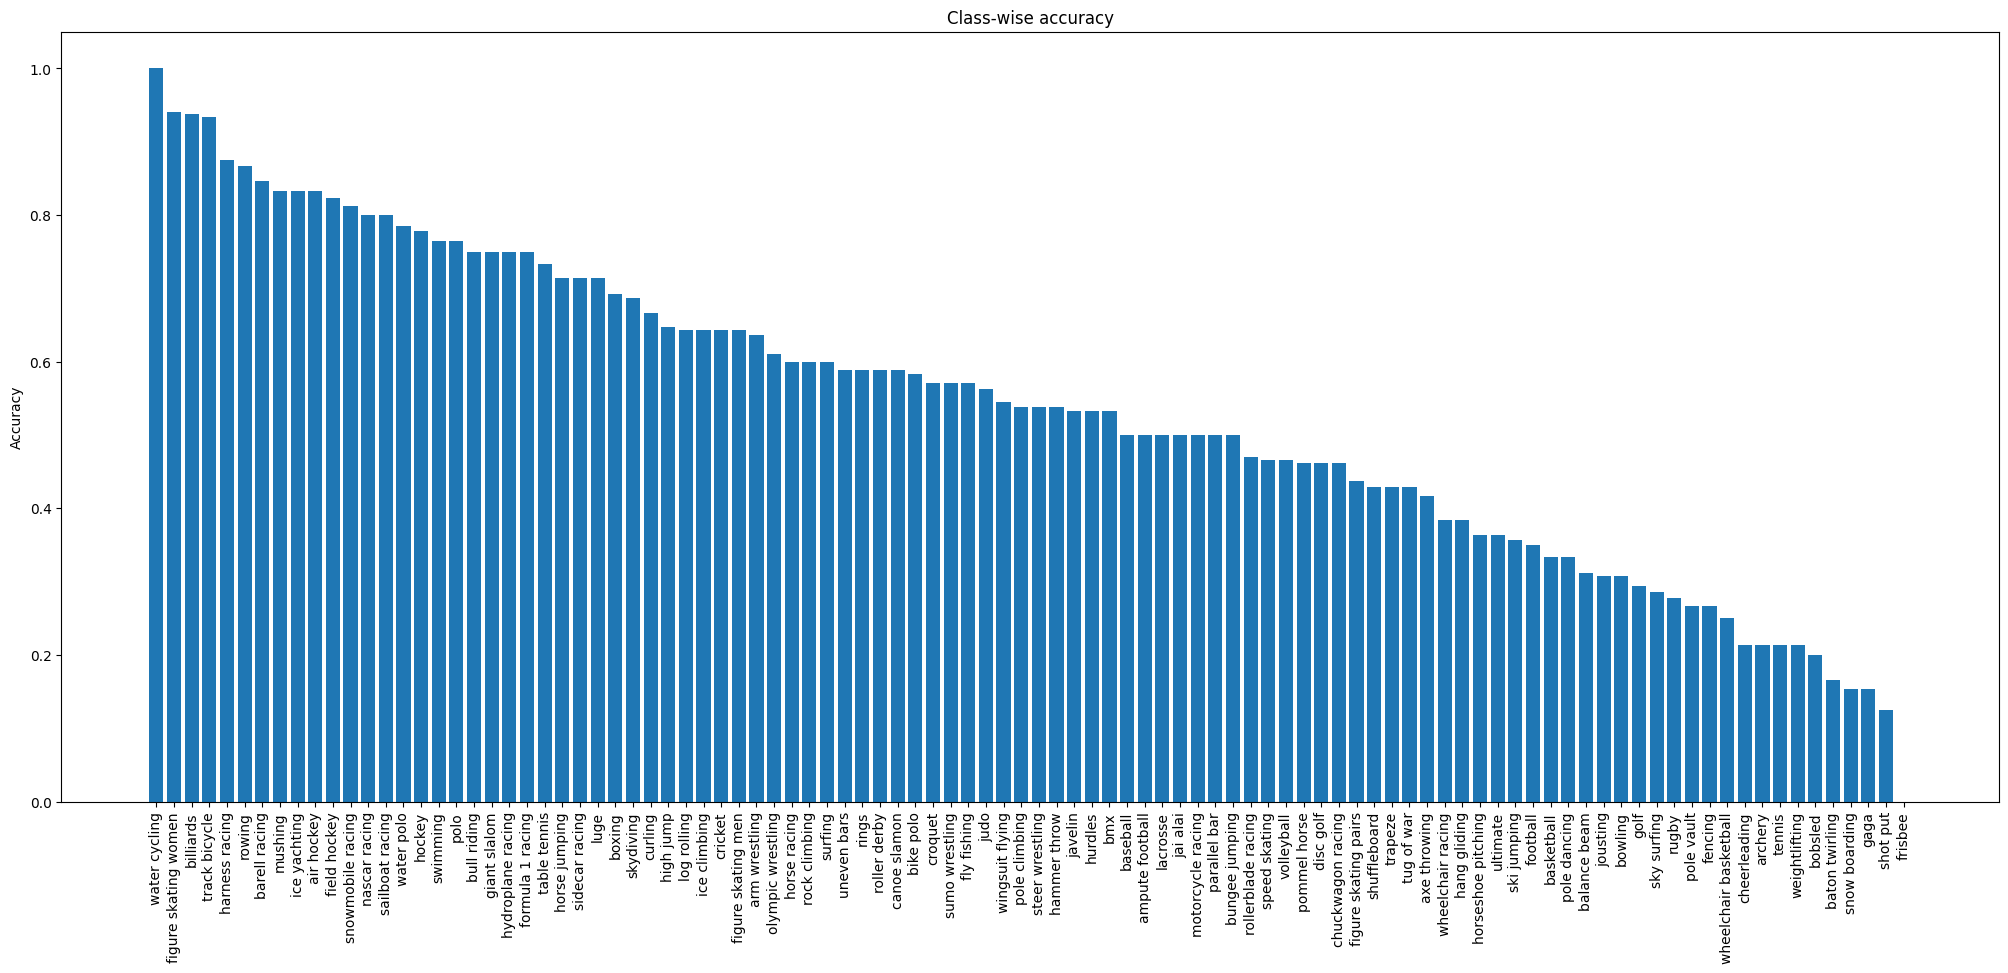

,class,accuracy
94,water cycling,1.000000
29,figure skating women,0.941176
11,billiards,0.937500
88,track bicycle,0.933333
39,harness racing,0.875000
70,rowing,0.866667
6,barell racing,0.846154
57,mushing,0.833333
48,ice yachting,0.833333
0,air hockey,0.833333


In [33]:
per_cls_acc = plot_classwise_accuracy(model, test_loader, class_names)
per_cls_acc.style.set_table_attributes('style="display:inline-block; height:300px; overflow:auto;"')

### ResNet18

In [23]:
num_classes = 100

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(512, num_classes)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

history = train_model(
            model, 
            train_loader, 
            valid_loader, 
            criterion=nn.CrossEntropyLoss(),
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=20,
            patience=5,
            device="cuda"
            )

### Per-class accuracy

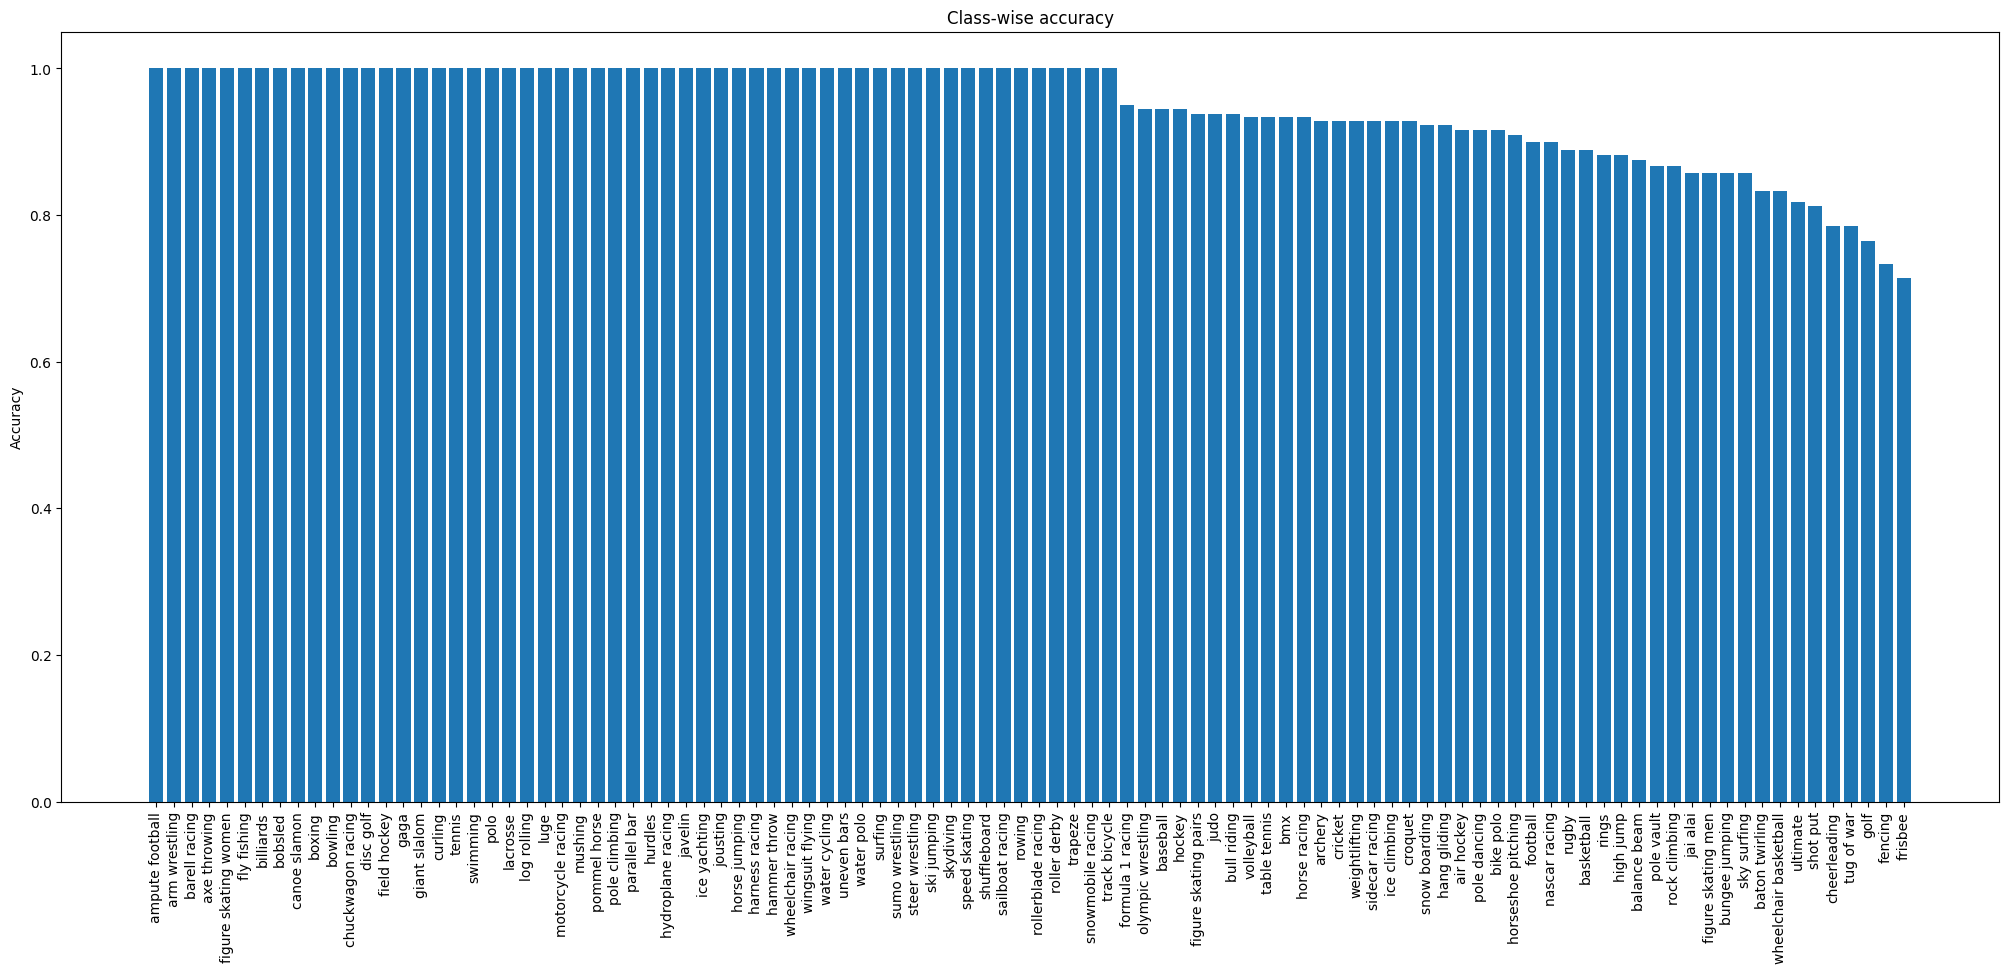

,class,accuracy
1,ampute football,1.000000
3,arm wrestling,1.000000
6,barell racing,1.000000
4,axe throwing,1.000000
29,figure skating women,1.000000
30,fly fishing,1.000000
11,billiards,1.000000
13,bobsled,1.000000
18,canoe slamon,1.000000
15,boxing,1.000000


In [25]:
per_cls_acc = plot_classwise_accuracy(model, test_loader, class_names)
per_cls_acc.style.set_table_attributes('style="display:inline-block; height:300px; overflow:auto;"')

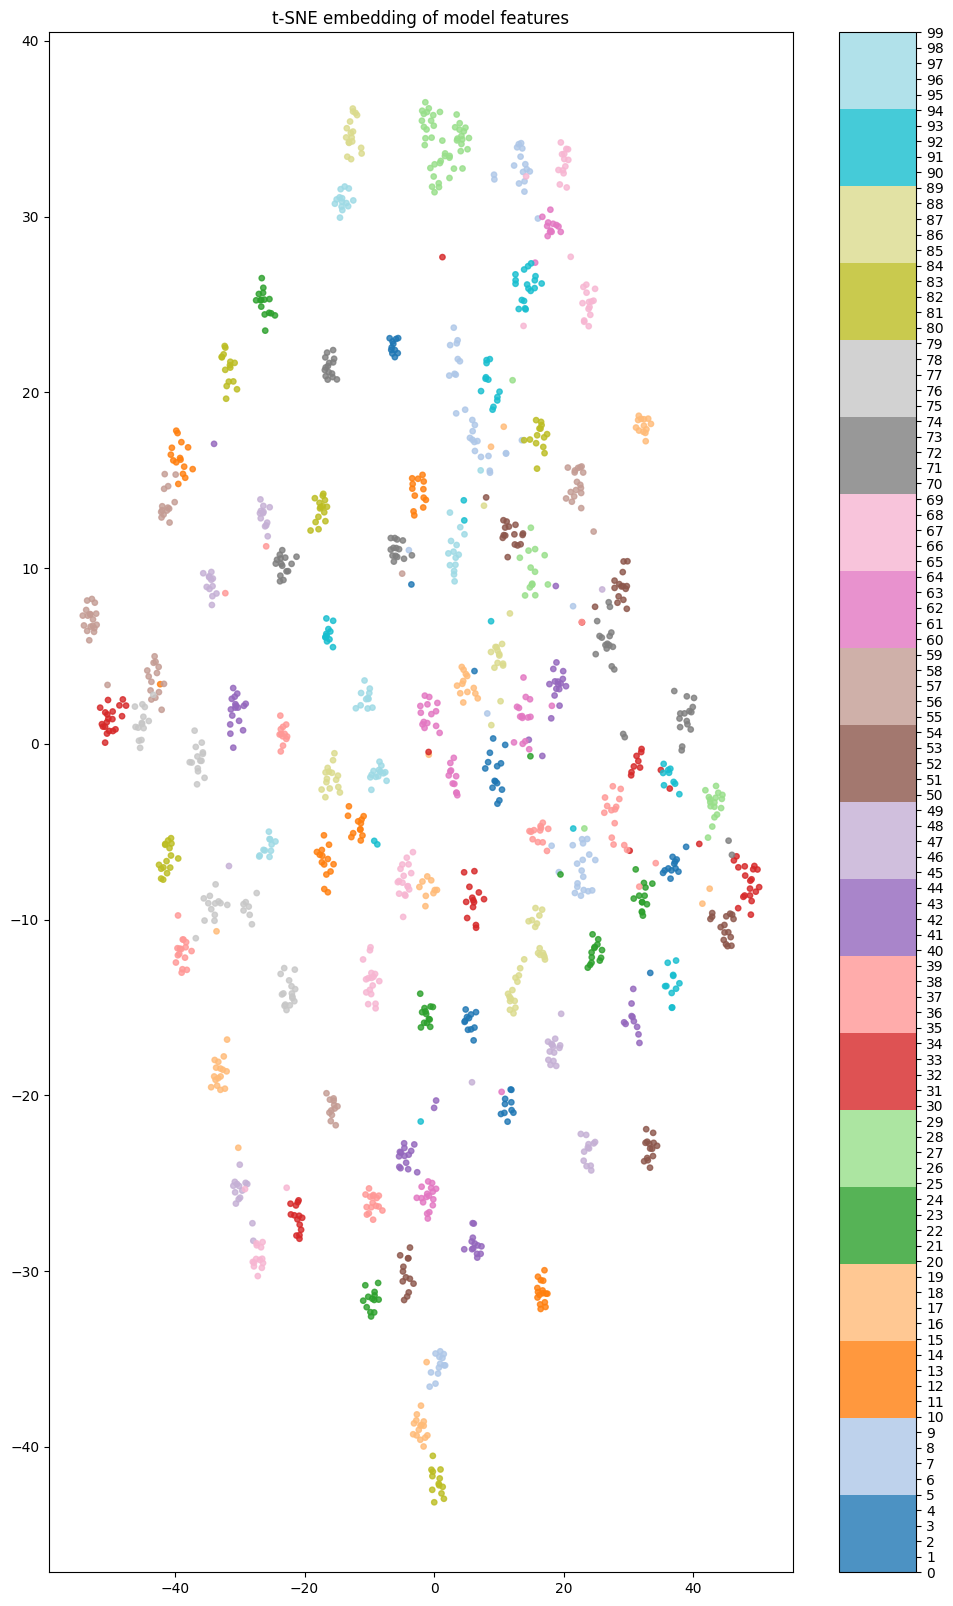

In [26]:
tsne_embedding(model, test_loader, class_names)